# Emergency Fund Predictor: The Glass Wallet
### KWK Machine Learning x Finance Challenge 2025
**Author:** Amelia Eckard

---

## Project Overview

This project examines young adults' ability to cover emergency expenses using machine learning to identify individual characteristics and geographic factors that create barriers to financial stability. Building on intersectionality theory, the "Glass Wallet" concept describes how overlapping barriers create invisible but impenetrable obstacles to financial security.

**Research Question:** What individual and geographic factors predict whether young adults can cover a $400 emergency expense?

**Key Finding:** 41.8% of Americans cannot cover a $400 emergency expense, revealing widespread financial fragility across demographic and geographic lines.

**Data Sources:**
- Federal Reserve's Survey of Household Economics and Decisionmaking (SHED) 2024 - 12,295 respondents
- Federal Reserve Economic Data (FRED) - State minimum wage data
- Bureau of Economic Analysis (BEA) - Regional Price Parities (cost of living)

**Model Performance:**
- Best Model: Gradient Boosting (Tuned)
- Accuracy: 83.6%
- F1 Score: 0.859
- ROC-AUC: 0.910

##Setup and Imports

In [89]:
!pip install pandas numpy scikit-learn matplotlib seaborn plotly imbalanced-learn shap -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import shap

import warnings
warnings.filterwarnings('ignore')

import time

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully")

✓ All libraries imported successfully


Data Loading

In [90]:
from google.colab import drive
drive.mount('/content/drive')

fred = pd.read_csv("/content/drive/My Drive/KWK_ML/Project/data/fredgraph.csv")
rpp = pd.read_excel("/content/drive/My Drive/KWK_ML/Project/data/rpp1224.xlsx", skiprows=5)
rpp.columns = ['state', 'real_pce_2022', 'real_pce_2023', 'pce_pct_change',
               'real_income_2022', 'real_income_2023', 'income_pct_change']
rpp['state'] = rpp['state'].str.lower().str.strip()
rpp = rpp[~rpp['state'].isin(['united states', 'nan', ''])]
rpp = rpp.dropna(subset=['state'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
print(f"FRED (Minimum Wage)")
print(f"Dataset shape: {fred.shape}")
print(f"Total samples: {len(fred):,}")
print(f"\nColumns: {fred.columns.tolist()}")

FRED (Minimum Wage)
Dataset shape: (58, 13)
Total samples: 58

Columns: ['observation_date', 'STTMINWGFG', 'STTMINWGAK', 'STTMINWGAR', 'STTMINWGAZ', 'STTMINWGCA', 'STTMINWGCO', 'STTMINWGCT', 'STTMINWGDE', 'STTMINWGFL', 'STTMINWGGA', 'STTMINWGHI', 'STTMINWGIA']


In [92]:
fred.head()

,observation_date,STTMINWGFG,STTMINWGAK,STTMINWGAR,STTMINWGAZ,STTMINWGCA,STTMINWGCO,STTMINWGCT,STTMINWGDE,STTMINWGFL,STTMINWGGA,STTMINWGHI,STTMINWGIA
0,1968-01-01,1.6,2.1,NaN,NaN,1.65,1.25,1.40,1.25,NaN,NaN,1.25,NaN
1,1969-01-01,1.6,2.1,NaN,NaN,1.65,1.25,1.40,1.25,NaN,NaN,1.25,NaN
2,1970-01-01,1.6,2.1,1.1,NaN,1.65,1.25,1.60,1.25,NaN,NaN,1.60,NaN
3,1971-01-01,1.6,2.1,1.1,NaN,1.65,1.25,1.60,1.25,NaN,NaN,1.60,NaN
4,1972-01-01,1.6,2.1,1.2,NaN,1.65,1.25,1.85,1.60,NaN,1.25,1.60,NaN


In [93]:
fred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  58 non-null     object 
 1   STTMINWGFG        58 non-null     float64
 2   STTMINWGAK        58 non-null     float64
 3   STTMINWGAR        56 non-null     float64
 4   STTMINWGAZ        19 non-null     float64
 5   STTMINWGCA        58 non-null     float64
 6   STTMINWGCO        58 non-null     float64
 7   STTMINWGCT        58 non-null     float64
 8   STTMINWGDE        58 non-null     float64
 9   STTMINWGFL        20 non-null     float64
 10  STTMINWGGA        52 non-null     float64
 11  STTMINWGHI        58 non-null     float64
 12  STTMINWGIA        35 non-null     float64
dtypes: float64(12), object(1)
memory usage: 6.0+ KB


In [94]:
print(f"SHED 2024 (Public)")
print(f"Dataset shape: {pub.shape}")
print(f"Total samples: {len(pub):,}")
print(f"\nColumns: {pub.columns.tolist()}")

SHED 2024 (Public)
Dataset shape: (12295, 754)
Total samples: 12,295

Columns: ['CaseID', 'caseid2023', 'caseid2022', 'duration', 'weight', 'weight_pop', 'panel_weight', 'panel_weight_pop', 'x2023', 'x2022', 'xlaptop', 'L0_a', 'L0_b', 'L0_c', 'L0_d', 'L0_e', 'L0B_a', 'L0B_b', 'L0B_c', 'L0C', 'L0E', 'B2', 'B3', 'B3A_a', 'B3A_b', 'B3A_c', 'B3A_d', 'B3A_e', 'B3B_a', 'B3B_b', 'B3B_c', 'B3B_d', 'B3B_e', 'B7_a', 'B7_b', 'X11_none', 'X12_a', 'X12_b', 'X12_c', 'X12_d', 'X12_e', 'X12_f', 'X12_g', 'X13', 'CG0', 'CG1A', 'CG2', 'CG7_a', 'CG7_b', 'CG7_c', 'CG7_d', 'CG7_e', 'CG7_f', 'CG7_g', 'CG9', 'CG8', 'CG3', 'CG4', 'CG5_a', 'CG5_b', 'CG5_c', 'CG5_d', 'CG5_e', 'CG5_f', 'CG6', 'D1A', 'D4', 'D48', 'D3B', 'D1E', 'D22_a', 'D22_b', 'D22_c', 'D22_d', 'D22_e', 'D22_f', 'D22_g', 'D22_h', 'D22_i', 'D3A', 'D3E', 'D28_a', 'D28_b', 'D30', 'D47', 'D34A', 'D36B', 'D44_f', 'D44_a', 'D44_b', 'D44_c', 'D44_d', 'D44_e', 'D37A', 'D38_a', 'D38_b', 'D38_c', 'D38_d', 'D38_f', 'D39', 'D1B', 'D5', 'D49', 'D41_a', 'D41_b

In [95]:
pub.head()

,CaseID,caseid2023,caseid2022,duration,weight,weight_pop,panel_weight,panel_weight_pop,x2023,x2022,...,E4_e_iflag,E4_f_iflag,CH2A_iflag,race_5cat,inc_4cat_50k,educ_4cat,pay_casheqv,atleast_okay,control,min_wage
0,1,1.0,1.0,1333,0.6149,12971.9817,1.2153,78509.7641,Yes,Yes,...,0,0,0,White,"$25,000–$49,999",Bachelor's degree or more,Yes,Yes,Public,7.25
1,2,NaN,2.0,975,0.8301,17511.2242,NaN,NaN,No,Yes,...,0,0,0,White,"$100,000 or more",Bachelor's degree or more,Yes,Yes,Public,7.25
2,3,7.0,NaN,2146,0.4447,9381.0980,0.8061,52078.4957,Yes,No,...,0,0,0,White,"$50,000–$99,999",Bachelor's degree or more,Yes,Yes,NaN,7.25
3,4,NaN,NaN,1214,0.8333,17580.0326,NaN,NaN,No,No,...,0,0,0,White,"$50,000–$99,999",High school degree or GED,Yes,Yes,NaN,7.25
4,5,NaN,9.0,1168,0.9064,19121.3763,NaN,NaN,No,Yes,...,0,0,0,White,"$50,000–$99,999",Some college/technical or associates degree,Yes,Yes,Public,13.00


In [96]:
pub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12295 entries, 0 to 12294
Columns: 754 entries, CaseID to min_wage
dtypes: float64(25), int64(354), object(375)
memory usage: 70.7+ MB


In [97]:
print(f"RPP (Regional Price Parities)")
print(f"Dataset shape: {rpp.shape}")
print(f"Total samples: {len(rpp):,}")
print(f"\nColumns: {rpp.columns.tolist()}")

RPP (Regional Price Parities)
Dataset shape: (55, 7)
Total samples: 55

Columns: ['state', 'real_pce_2022', 'real_pce_2023', 'pce_pct_change', 'real_income_2022', 'real_income_2023', 'income_pct_change']


In [98]:
rpp.head()

,state,real_pce_2022,real_pce_2023,pce_pct_change,real_income_2022,real_income_2023,income_pct_change
0,arizona,321902.0,328923.0,2.2,374593.0,381769.0,1.9
1,arkansas,127802.0,130245.0,1.9,167212.0,169738.0,1.5
2,california,1815443.0,1862352.0,2.6,2300588.0,2335587.0,1.5
3,colorado,295601.0,306885.0,3.8,377586.0,385504.0,2.1
4,connecticut,179159.0,188561.0,5.2,248931.0,260583.0,4.7


In [99]:
rpp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, 0 to 55
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state              55 non-null     object 
 1   real_pce_2022      52 non-null     float64
 2   real_pce_2023      52 non-null     float64
 3   pce_pct_change     52 non-null     float64
 4   real_income_2022   52 non-null     float64
 5   real_income_2023   52 non-null     float64
 6   income_pct_change  52 non-null     float64
dtypes: float64(6), object(1)
memory usage: 3.4+ KB


Exploratory Data Analysis (EDA)

In [100]:
fred.describe()

,STTMINWGFG,STTMINWGAK,STTMINWGAR,STTMINWGAZ,STTMINWGCA,STTMINWGCO,STTMINWGCT,STTMINWGDE,STTMINWGFL,STTMINWGGA,STTMINWGHI,STTMINWGIA
count,58.000000,58.000000,56.000000,19.000000,58.000000,58.000000,58.000000,58.000000,20.000000,52.000000,58.000000,35.000000
mean,4.636207,5.766207,4.945536,9.805263,6.013793,5.086552,6.028793,5.132759,8.521500,3.640000,5.496552,6.121429
std,2.011301,2.831142,2.893524,2.764100,3.982713,3.856311,3.819231,3.271200,1.789788,1.968085,3.238554,1.195229
min,1.600000,2.100000,1.100000,6.750000,1.650000,1.250000,1.400000,1.250000,6.400000,1.230000,1.250000,4.250000
25%,3.350000,3.850000,2.700000,7.500000,3.350000,1.900000,3.370000,2.000000,7.250000,1.250000,3.100000,5.150000
50%,4.500000,5.000000,4.700000,8.050000,4.500000,3.875000,4.520000,4.825000,8.050000,3.250000,5.250000,7.250000
75%,7.250000,7.750000,6.250000,12.075000,8.000000,7.340000,8.250000,7.250000,8.920000,5.150000,7.250000,7.250000
max,7.250000,11.910000,11.000000,14.700000,16.500000,14.810000,16.350000,15.000000,13.000000,7.250000,14.000000,7.250000


In [101]:
pub.describe()

,CaseID,caseid2023,caseid2022,duration,weight,weight_pop,panel_weight,panel_weight_pop,CG2,R3,...,E2A_iflag,E2B_iflag,E4_a_iflag,E4_b_iflag,E4_c_iflag,E4_d_iflag,E4_e_iflag,E4_f_iflag,CH2A_iflag,min_wage
count,12295.000000,4039.000000,3853.000000,1.229500e+04,12295.000000,12295.000000,4015.000000,4015.00000,483.000000,3201.000000,...,12295.000000,12295.000000,12295.000000,12295.000000,12295.000000,12295.000000,12295.000000,12295.000000,12295.000000,12295.000000
mean,6383.407564,5549.327061,8957.120166,1.367906e+04,0.999998,21096.509312,1.000000,64603.13375,312.296066,1372.120587,...,0.002196,0.003904,0.009028,0.016673,0.010655,0.019845,0.018788,0.017649,0.002440,9.188444
std,3694.987134,3079.649241,10423.569397,6.477207e+04,0.435112,9179.335914,0.421962,27260.01214,357.599113,996.913249,...,0.046812,0.062363,0.094590,0.128050,0.102675,0.139475,0.135782,0.131679,0.049338,3.456657
min,1.000000,1.000000,1.000000,3.850000e+02,0.178800,3771.794000,0.094300,6094.60200,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.250000
25%,3192.500000,2953.500000,3231.000000,9.940000e+02,0.716300,15111.396900,0.717700,46365.26360,101.500000,725.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.250000
50%,6376.000000,5554.000000,6142.000000,1.319000e+03,0.924400,19502.656900,0.897800,57999.59550,225.000000,1200.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.250000
75%,9575.500000,8072.500000,9162.000000,2.032000e+03,1.172700,24740.515400,1.220600,78854.04785,400.000000,1750.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000
max,12818.000000,11484.000000,48356.000000,1.038184e+06,3.515900,74172.699500,3.290200,212555.40500,4000.000000,9999.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.500000


In [102]:
rpp.describe()

,real_pce_2022,real_pce_2023,pce_pct_change,real_income_2022,real_income_2023,income_pct_change
count,5.200000e+01,5.200000e+01,52.000000,5.200000e+01,5.200000e+01,52.000000
mean,3.578747e+05,3.670970e+05,2.832692,4.483747e+05,4.572462e+05,2.326923
std,4.471705e+05,4.592369e+05,1.942580,5.637163e+05,5.737723e+05,2.058470
min,2.940700e+04,3.038100e+04,-0.600000,3.514700e+04,3.724300e+04,-2.000000
25%,7.924050e+04,8.136175e+04,1.350000,9.954725e+04,1.013032e+05,1.075000
50%,1.973715e+05,2.021760e+05,2.350000,2.462990e+05,2.567945e+05,2.000000
75%,3.988410e+05,4.133185e+05,3.825000,5.173345e+05,5.331750e+05,3.725000
max,1.815443e+06,1.862352e+06,7.900000,2.300588e+06,2.335587e+06,8.000000


In [103]:
# Data Cleaning and Merging
pub = pd.read_csv("/content/drive/My Drive/KWK_ML/Project/data/public2024.csv")

state_abbrev = {
    'alabama': 'al', 'alaska': 'ak', 'arizona': 'az', 'arkansas': 'ar',
    'california': 'ca', 'colorado': 'co', 'connecticut': 'ct', 'delaware': 'de',
    'florida': 'fl', 'georgia': 'ga', 'hawaii': 'hi', 'idaho': 'id',
    'illinois': 'il', 'indiana': 'in', 'iowa': 'ia', 'kansas': 'ks',
    'kentucky': 'ky', 'louisiana': 'la', 'maine': 'me', 'maryland': 'md',
    'massachusetts': 'ma', 'michigan': 'mi', 'minnesota': 'mn', 'mississippi': 'ms',
    'missouri': 'mo', 'montana': 'mt', 'nebraska': 'ne', 'nevada': 'nv',
    'new hampshire': 'nh', 'new jersey': 'nj', 'new mexico': 'nm', 'new york': 'ny',
    'north carolina': 'nc', 'north dakota': 'nd', 'ohio': 'oh', 'oklahoma': 'ok',
    'oregon': 'or', 'pennsylvania': 'pa', 'rhode island': 'ri', 'south carolina': 'sc',
    'south dakota': 'sd', 'tennessee': 'tn', 'texas': 'tx', 'utah': 'ut',
    'vermont': 'vt', 'virginia': 'va', 'washington': 'wa', 'west virginia': 'wv',
    'wisconsin': 'wi', 'wyoming': 'wy', 'district of columbia': 'dc'
}

rpp['state_abbrev'] = rpp['state'].map(state_abbrev)

fred_clean = fred.iloc[-1:].copy()
fred_clean = fred_clean.drop('observation_date', axis=1)
fred_long = fred_clean.melt(var_name='state_code', value_name='min_wage')
fred_long['state'] = fred_long['state_code'].str.replace('STTMINWG', '').str.lower()
fred_long = fred_long[['state', 'min_wage']].copy()
fred_long = fred_long.dropna(subset=['min_wage'])

all_states = pub['ppstaten'].unique()
fred_complete = pd.DataFrame({'state': all_states})
fred_complete = fred_complete.merge(fred_long, on='state', how='left')
fred_complete['min_wage'] = fred_complete['min_wage'].fillna(7.25)

pub = pub.merge(fred_complete, left_on='ppstaten', right_on='state', how='left')
pub = pub.drop('state', axis=1)

pub = pub.merge(rpp[['state_abbrev', 'real_pce_2022', 'real_pce_2023', 'pce_pct_change',
                      'real_income_2022', 'real_income_2023', 'income_pct_change']],
                left_on='ppstaten', right_on='state_abbrev', how='left')
pub = pub.drop('state_abbrev', axis=1)

print(f"Merged dataset: {pub.shape}")
print(f"Min wage coverage: {pub['min_wage'].notna().sum() / len(pub) * 100:.1f}%")
print(f"RPP coverage: {pub['real_income_2023'].notna().sum() / len(pub) * 100:.1f}%")

# Preprocessing
missing_pct = (pub.isnull().sum() / len(pub)) * 100
high_missing = missing_pct[missing_pct > 50]
pub_clean = pub.drop(columns=high_missing.index.tolist())

numeric_cols = pub_clean.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = pub_clean.select_dtypes(include=['object']).columns

for col in numeric_cols:
    if pub_clean[col].isna().sum() > 0:
        pub_clean[col].fillna(pub_clean[col].median(), inplace=True)

for col in categorical_cols:
    if pub_clean[col].isna().sum() > 0:
        mode_value = pub_clean[col].mode()
        if len(mode_value) > 0:
            pub_clean[col].fillna(mode_value[0], inplace=True)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
pub_clean['ef1_binary'] = le.fit_transform(pub_clean['EF1'])
pub_clean = pub_clean.drop('EF1', axis=1)

categorical_cols = pub_clean.select_dtypes(include=['object']).columns
pub_encoded = pd.get_dummies(pub_clean, columns=categorical_cols, drop_first=True)

y = pub_encoded['ef1_binary']
X = pub_encoded.drop('ef1_binary', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nPreprocessing complete:")
print(f"Training: {X_train_scaled.shape}")
print(f"Test: {X_test_scaled.shape}")
print(f"Features: {X.shape[1]}")
print(f"Class distribution: {y_train.value_counts(normalize=True).to_dict()}")

Merged dataset: (12295, 760)
Min wage coverage: 100.0%
RPP coverage: 98.4%

Preprocessing complete:
Training: (9836, 838)
Test: (2459, 838)
Features: 838
Class distribution: {1: 0.5816388775925173, 0: 0.41836112240748274}



1. TARGET VARIABLE: Ability to Cover $400 Emergency


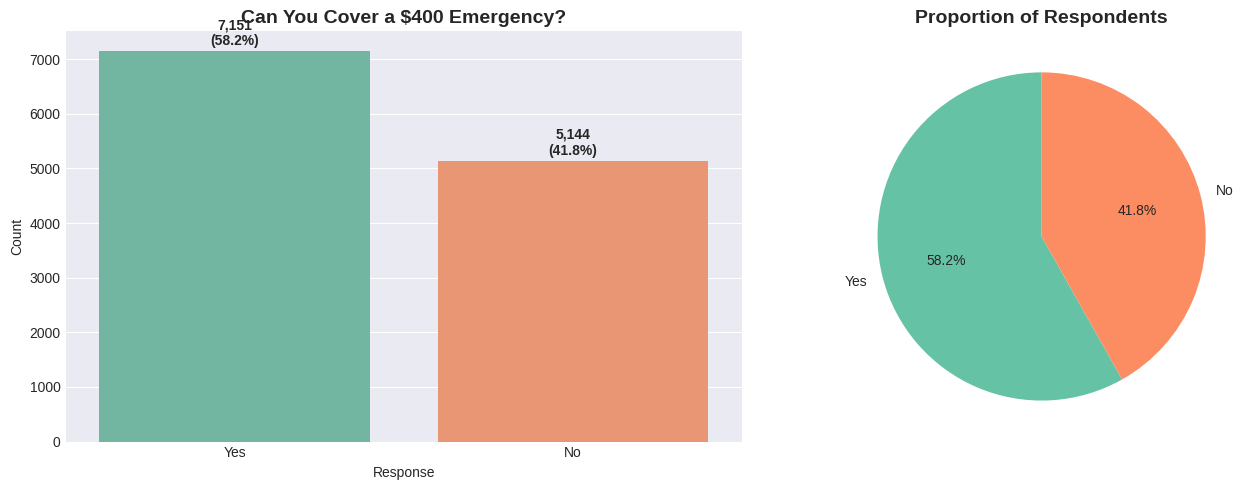


2. MINIMUM WAGE BY STATE


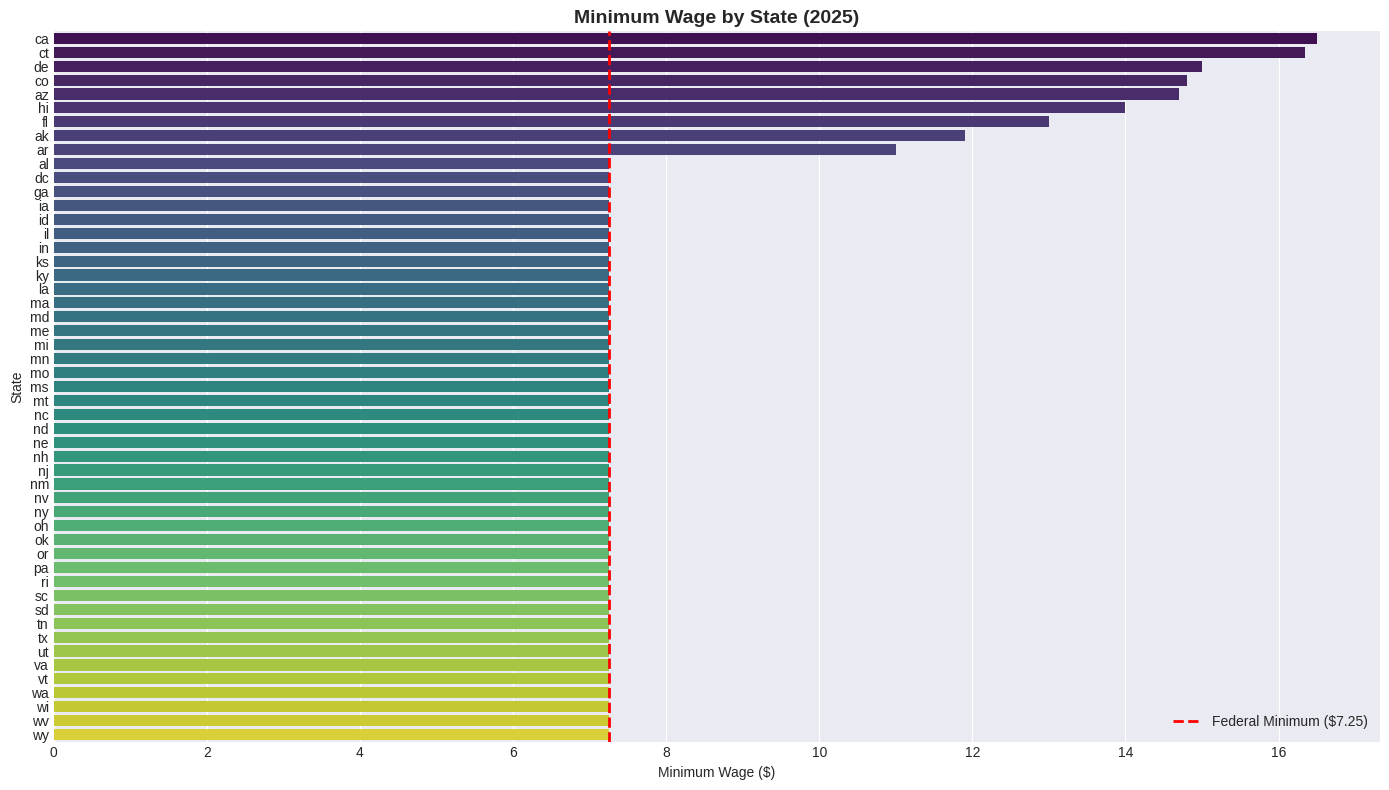

States with federal minimum: 42
States above federal: 9
Highest: ca ($16.5)

3. EMERGENCY FUND COVERAGE BY STATE


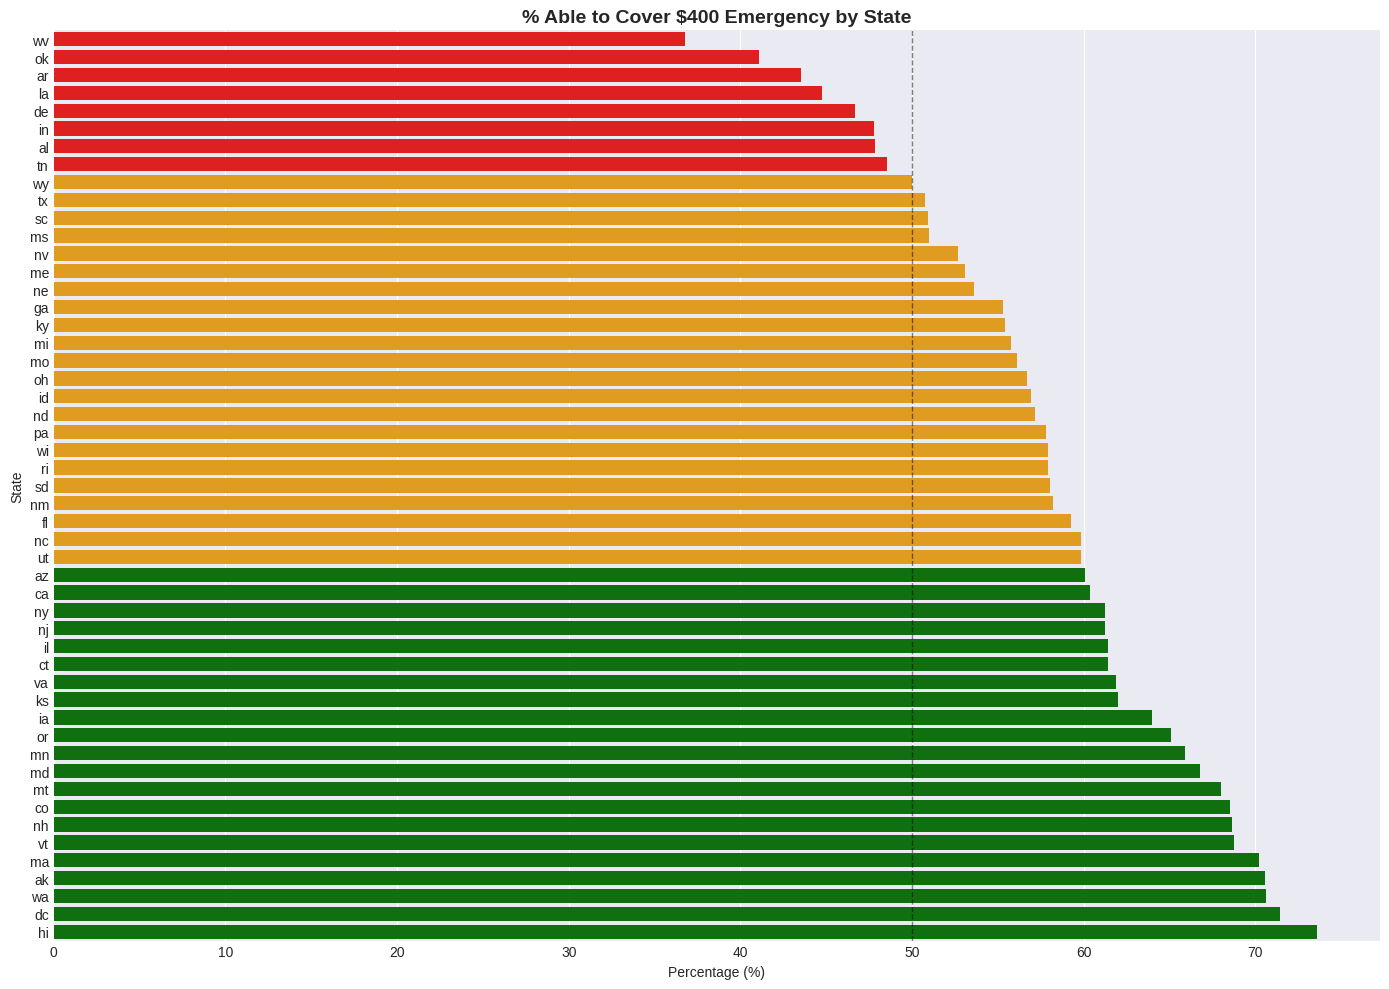

Worst state: wv (36.8%)
Best state: hi (73.6%)

4. ECONOMIC INDICATORS VS EMERGENCY FUND COVERAGE


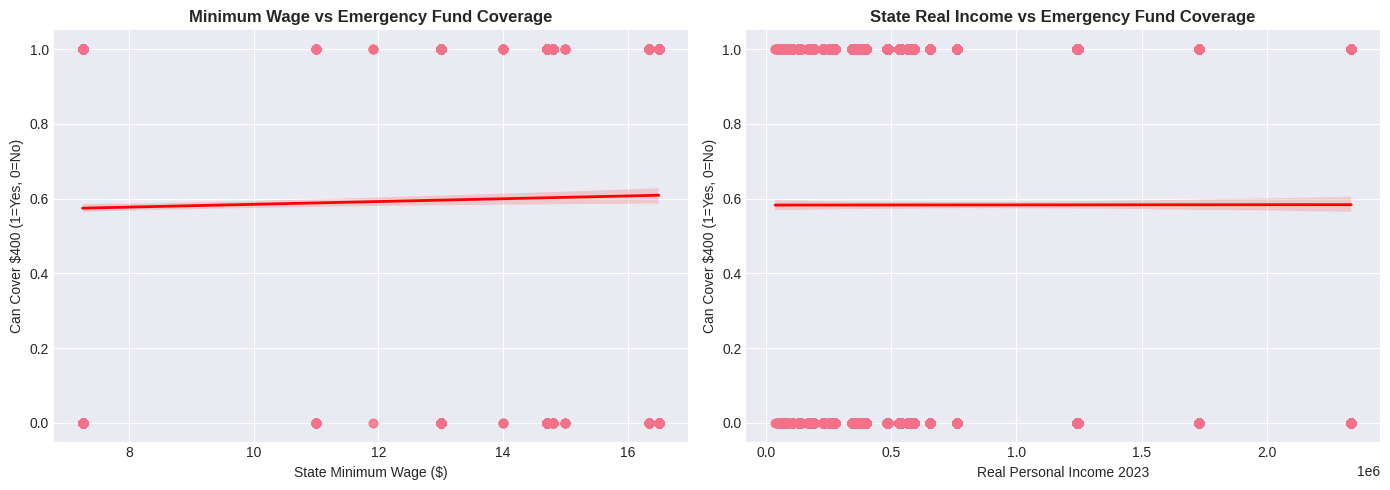


5. EMERGENCY FUND COVERAGE BY DEMOGRAPHICS


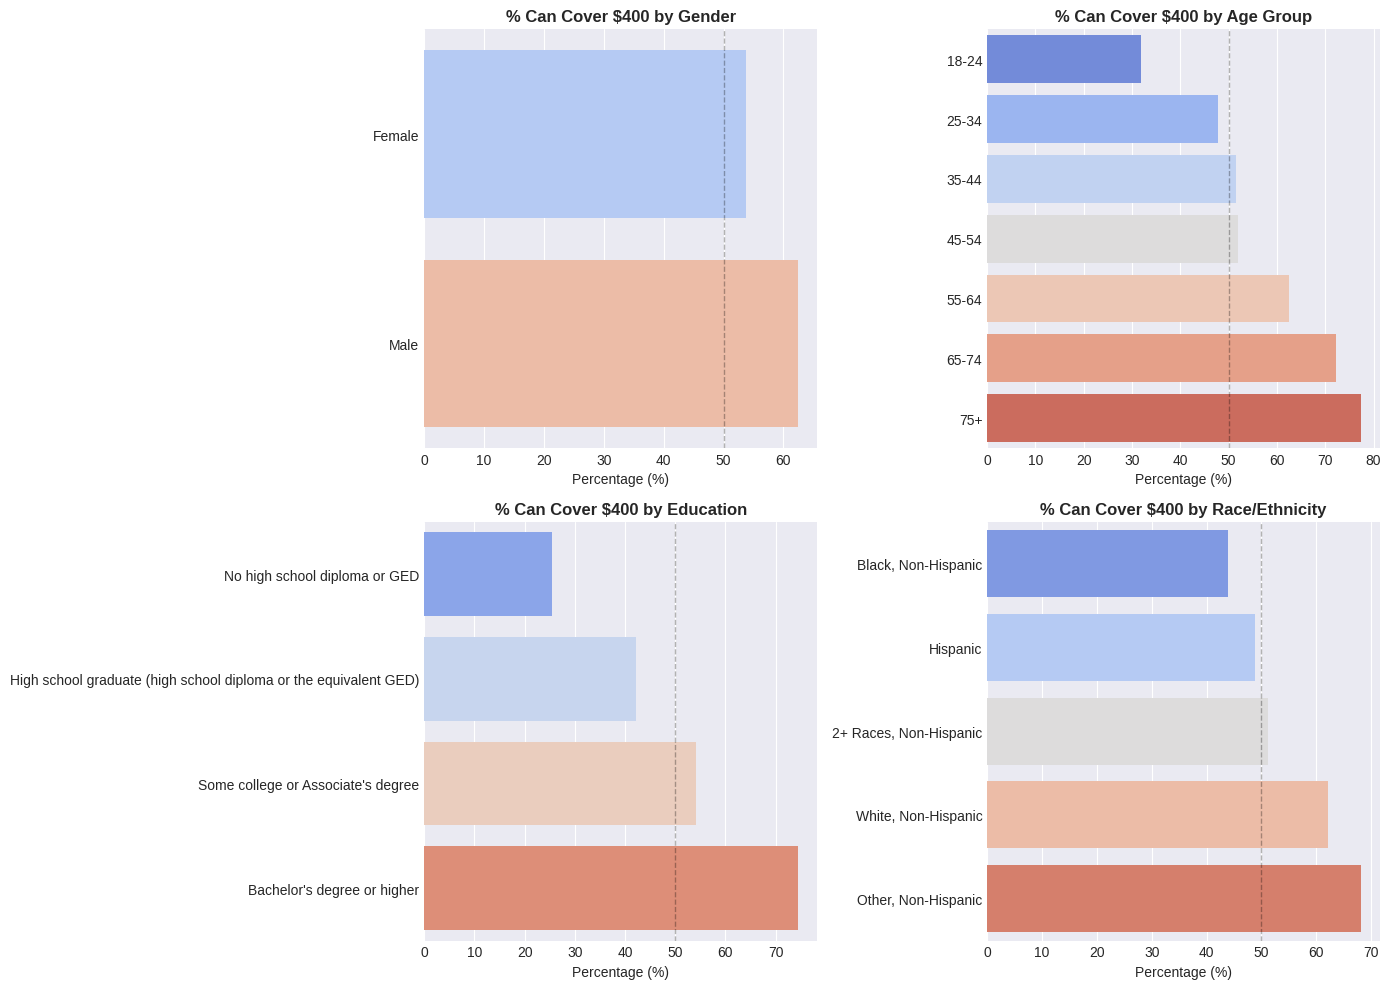

In [104]:
# Target variable distribution
print("\n1. TARGET VARIABLE: Ability to Cover $400 Emergency")
target_counts = pub['EF1'].value_counts()
target_pct = pub['EF1'].value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(data=pub, x='EF1', ax=axes[0], palette='Set2')
axes[0].set_title('Can You Cover a $400 Emergency?', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Response')
axes[0].set_ylabel('Count')
for i, v in enumerate(target_counts):
    axes[0].text(i, v + 100, f'{v:,}\n({target_pct.iloc[i]:.1f}%)', ha='center', fontweight='bold')

axes[1].pie(target_counts, labels=target_counts.index, autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette('Set2'))
axes[1].set_title('Proportion of Respondents', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Minimum wage distribution by state
print("\n2. MINIMUM WAGE BY STATE")
state_wage = pub.groupby('ppstaten')['min_wage'].first().sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=state_wage.values, y=state_wage.index, palette='viridis')
plt.title('Minimum Wage by State (2025)', fontsize=14, fontweight='bold')
plt.xlabel('Minimum Wage ($)')
plt.ylabel('State')
plt.axvline(7.25, color='red', linestyle='--', linewidth=2, label='Federal Minimum ($7.25)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"States with federal minimum: {(state_wage == 7.25).sum()}")
print(f"States above federal: {(state_wage > 7.25).sum()}")
print(f"Highest: {state_wage.index[0]} (${state_wage.iloc[0]})")

# Emergency fund coverage by state
print("\n3. EMERGENCY FUND COVERAGE BY STATE")
state_coverage = pub.groupby('ppstaten')['EF1'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100).sort_values()

plt.figure(figsize=(14, 10))
colors = ['red' if x < 50 else 'orange' if x < 60 else 'green' for x in state_coverage.values]
sns.barplot(x=state_coverage.values, y=state_coverage.index, palette=colors)
plt.title('% Able to Cover $400 Emergency by State', fontsize=14, fontweight='bold')
plt.xlabel('Percentage (%)')
plt.ylabel('State')
plt.axvline(50, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.show()

print(f"Worst state: {state_coverage.index[0]} ({state_coverage.iloc[0]:.1f}%)")
print(f"Best state: {state_coverage.index[-1]} ({state_coverage.iloc[-1]:.1f}%)")

# Economic indicators vs emergency fund
print("\n4. ECONOMIC INDICATORS VS EMERGENCY FUND COVERAGE")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

pub['can_cover'] = (pub['EF1'] == 'Yes').astype(int)

axes[0].scatter(pub['min_wage'], pub['can_cover'], alpha=0.3)
sns.regplot(data=pub, x='min_wage', y='can_cover', ax=axes[0],
            scatter=False, color='red', line_kws={'linewidth': 2})
axes[0].set_title('Minimum Wage vs Emergency Fund Coverage', fontsize=12, fontweight='bold')
axes[0].set_xlabel('State Minimum Wage ($)')
axes[0].set_ylabel('Can Cover $400 (1=Yes, 0=No)')

axes[1].scatter(pub['real_income_2023'], pub['can_cover'], alpha=0.3)
sns.regplot(data=pub, x='real_income_2023', y='can_cover', ax=axes[1],
            scatter=False, color='red', line_kws={'linewidth': 2})
axes[1].set_title('State Real Income vs Emergency Fund Coverage', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Real Personal Income 2023')
axes[1].set_ylabel('Can Cover $400 (1=Yes, 0=No)')
plt.tight_layout()
plt.show()

# Demographics
print("\n5. EMERGENCY FUND COVERAGE BY DEMOGRAPHICS")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

demo_vars = [
    ('ppgender', 'Gender', axes[0,0]),
    ('ppagecat', 'Age Group', axes[0,1]),
    ('ppeducat', 'Education', axes[1,0]),
    ('ppethm', 'Race/Ethnicity', axes[1,1])
]

for var, title, ax in demo_vars:
    if var in pub.columns:
        demo_data = pub.groupby(var)['EF1'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100).sort_values()
        sns.barplot(x=demo_data.values, y=demo_data.index, ax=ax, palette='coolwarm')
        ax.set_title(f'% Can Cover $400 by {title}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Percentage (%)')
        ax.set_ylabel('')
        ax.axvline(50, color='black', linestyle='--', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

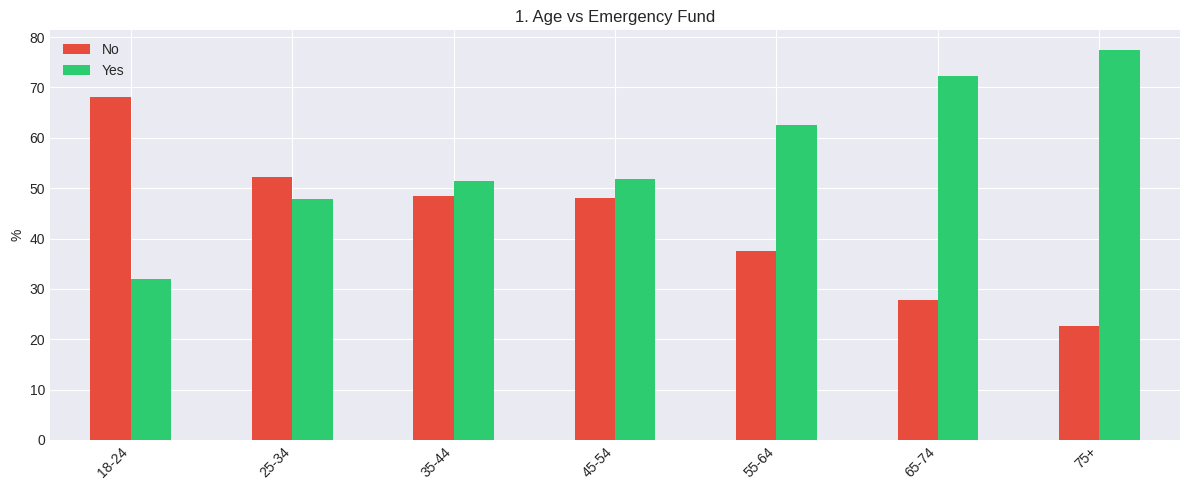

1. Age:
EF1         No   Yes
ppagecat            
18-24     68.1  31.9
25-34     52.2  47.8
35-44     48.5  51.5
45-54     48.1  51.9
55-64     37.4  62.6
65-74     27.8  72.2
75+       22.5  77.5


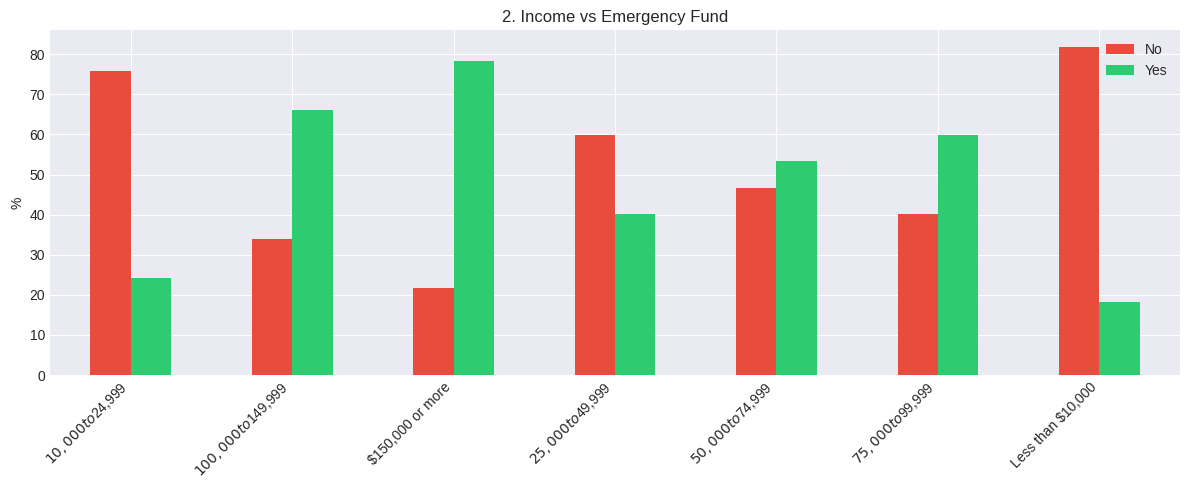

2. Income:
EF1                     No   Yes
ppinc7                          
$10,000 to $24,999    75.7  24.3
$100,000 to $149,999  33.9  66.1
$150,000 or more      21.6  78.4
$25,000 to $49,999    59.7  40.3
$50,000 to $74,999    46.6  53.4
$75,000 to $99,999    40.1  59.9
Less than $10,000     81.8  18.2


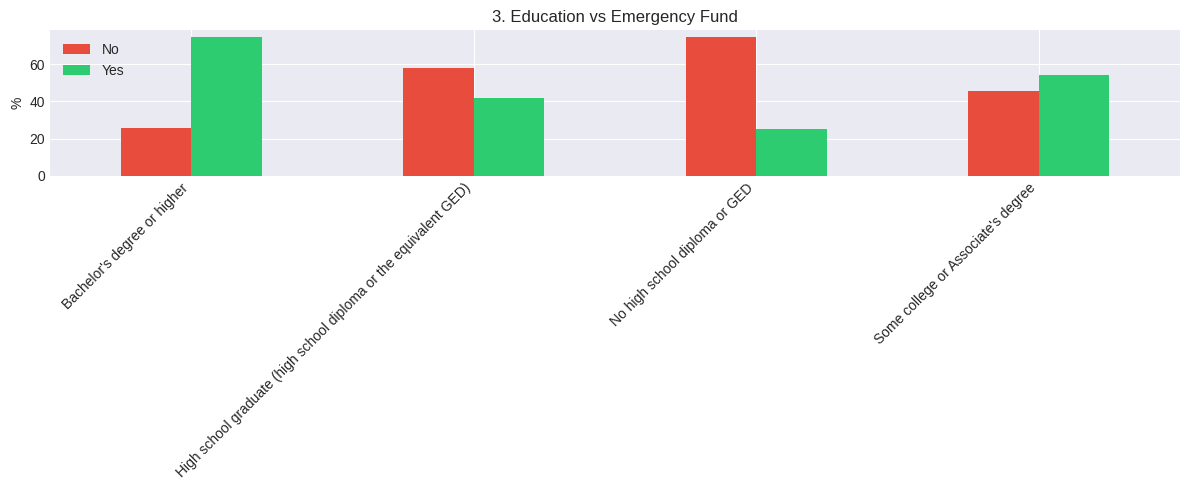

3. Education:
EF1                                                   No   Yes
ppeducat                                                      
Bachelor's degree or higher                         25.5  74.5
High school graduate (high school diploma or th...  57.9  42.1
No high school diploma or GED                       74.6  25.4
Some college or Associate's degree                  45.8  54.2


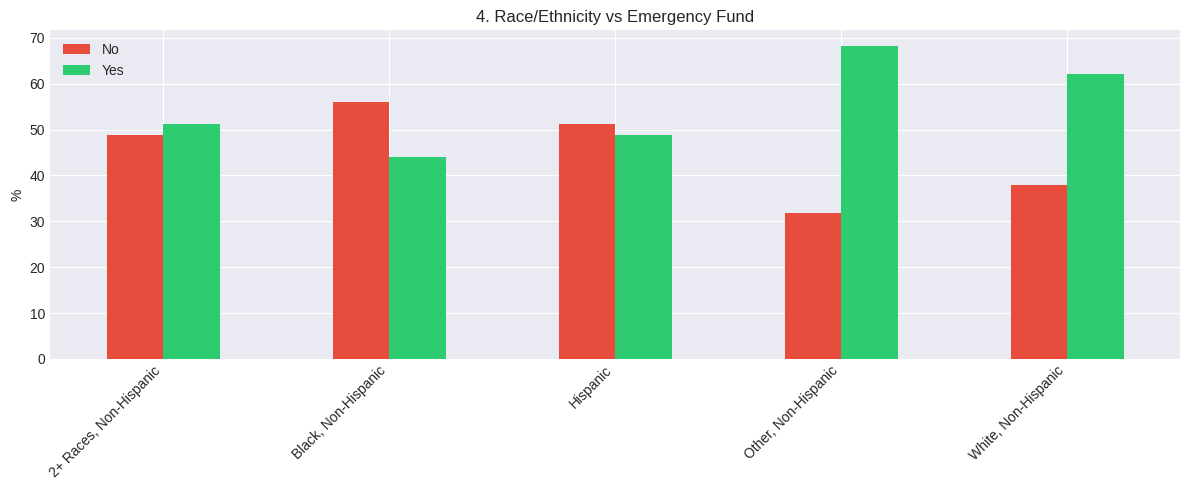

4. Race/Ethnicity:
EF1                       No   Yes
ppethm                            
2+ Races, Non-Hispanic  48.9  51.1
Black, Non-Hispanic     56.1  43.9
Hispanic                51.2  48.8
Other, Non-Hispanic     31.8  68.2
White, Non-Hispanic     37.9  62.1


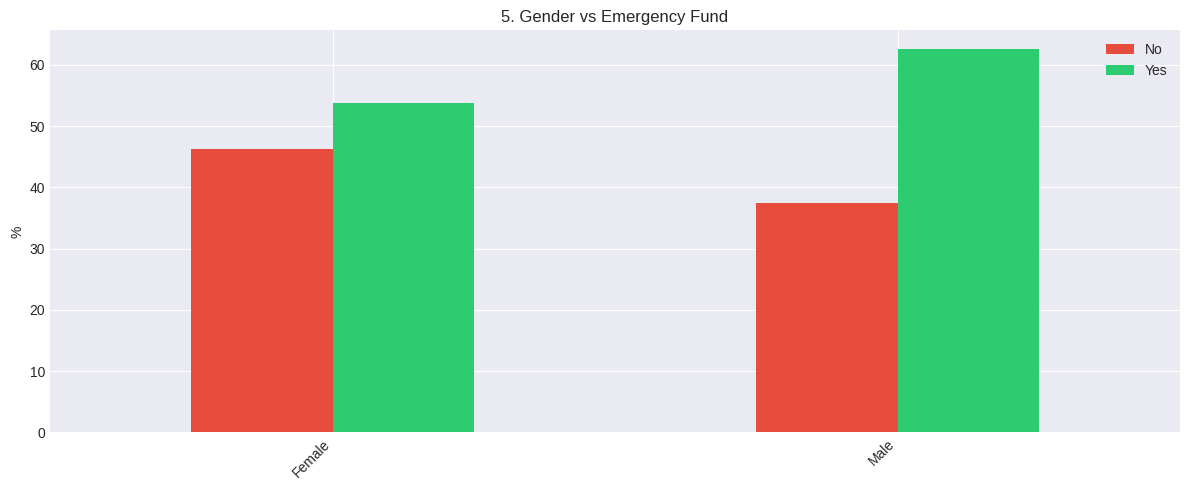

5. Gender:
EF1         No   Yes
ppgender            
Female    46.3  53.7
Male      37.5  62.5


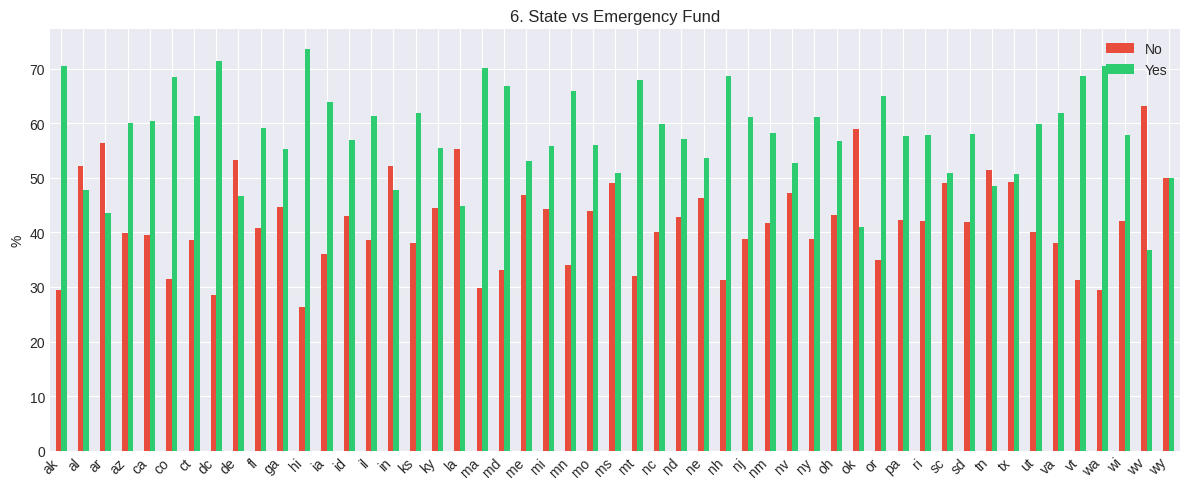

6. State:
EF1         No   Yes
ppstaten            
ak        29.4  70.6
al        52.2  47.8
ar        56.5  43.5
az        39.9  60.1
ca        39.6  60.4
co        31.5  68.5
ct        38.6  61.4
dc        28.6  71.4
de        53.3  46.7
fl        40.7  59.3
ga        44.7  55.3
hi        26.4  73.6
ia        36.0  64.0
id        43.1  56.9
il        38.6  61.4
in        52.2  47.8
ks        38.0  62.0
ky        44.6  55.4
la        55.2  44.8
ma        29.8  70.2
md        33.2  66.8
me        46.9  53.1
mi        44.2  55.8
mn        34.1  65.9
mo        43.9  56.1
ms        49.0  51.0
mt        32.0  68.0
nc        40.1  59.9
nd        42.9  57.1
ne        46.4  53.6
nh        31.4  68.6
nj        38.7  61.3
nm        41.8  58.2
nv        47.3  52.7
ny        38.8  61.2
oh        43.3  56.7
ok        58.9  41.1
or        34.9  65.1
pa        42.2  57.8
ri        42.1  57.9
sc        49.0  51.0
sd        41.9  58.1
tn        51.5  48.5
tx        49.2  50.8
ut        40.1  59.9
va 

In [105]:
demo_cols = {'Age': 'ppagecat', 'Income': 'ppinc7', 'Education': 'ppeducat',
             'Race/Ethnicity': 'ppethm', 'Gender': 'ppgender', 'State': 'ppstaten'}

for i, (category, col) in enumerate(demo_cols.items(), 1):
    if col in pub.columns:
        ct = pd.crosstab(pub[col], pub['EF1'], normalize='index') * 100
        ct = ct.sort_index()

        ct.plot(kind='bar', figsize=(12, 5), color=['#e74c3c', '#2ecc71'])
        plt.title(f'{i}. {category} vs Emergency Fund')
        plt.xlabel('')
        plt.ylabel('%')
        plt.legend(title='', labels=['No', 'Yes'])
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        print(f"{i}. {category}:")
        print(ct.round(1))

### Geographic Analysis

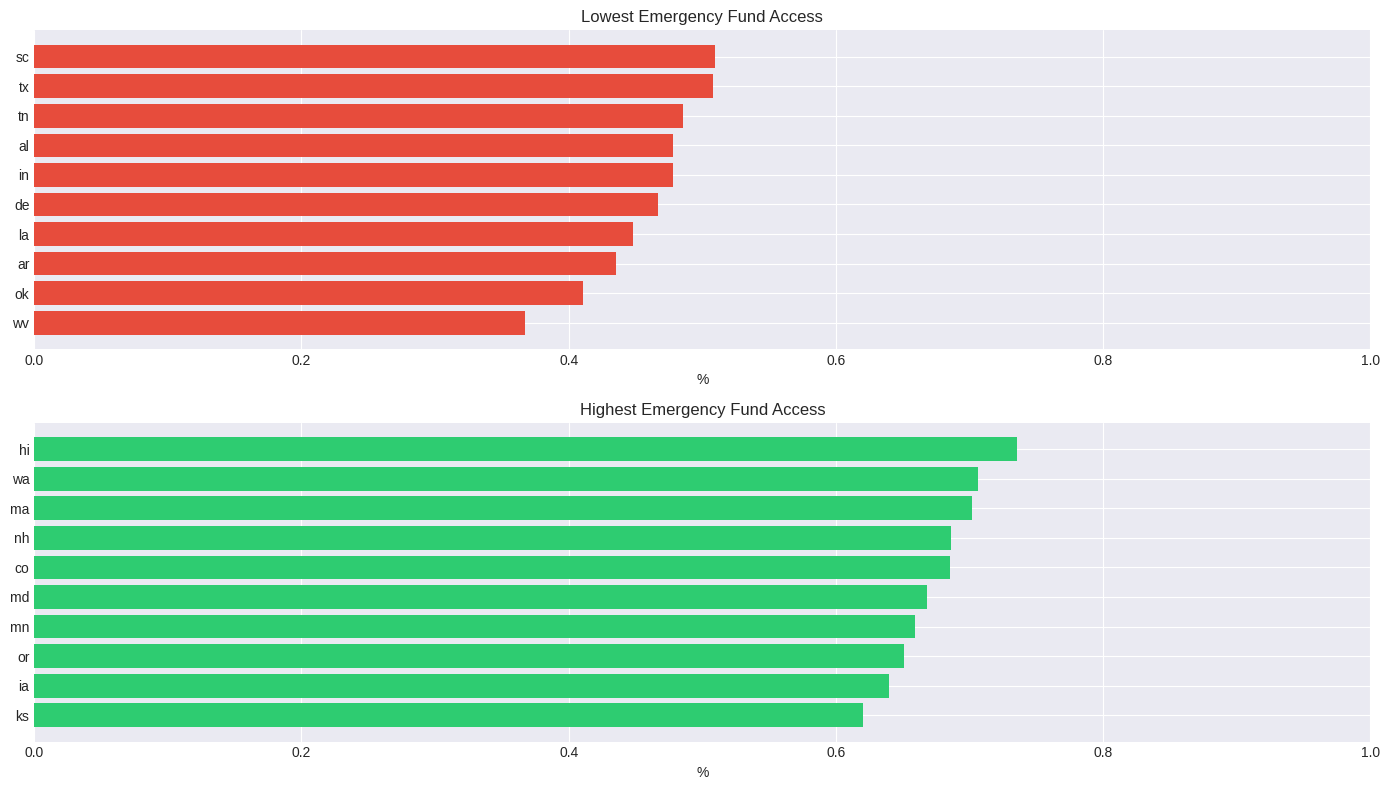

Lowest: wv (36.8%)
Highest: hi (73.6%)
Gap: 36.8%


In [106]:
pub['ef1_binary'] = (pub['EF1'] == 'Yes').astype(int)

state_analysis = pub.groupby('ppstaten').agg({
    'ef1_binary': ['count', 'mean']
})
state_analysis.columns = ['n', 'pct_cover']
state_analysis = state_analysis[state_analysis['n'] >= 30].sort_values('pct_cover')

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

worst = state_analysis.head(10)
axes[0].barh(range(len(worst)), worst['pct_cover'], color='#e74c3c')
axes[0].set_yticks(range(len(worst)))
axes[0].set_yticklabels(worst.index)
axes[0].set_xlabel('%')
axes[0].set_title('Lowest Emergency Fund Access')
axes[0].set_xlim(0, 1)

best = state_analysis.tail(10)
axes[1].barh(range(len(best)), best['pct_cover'], color='#2ecc71')
axes[1].set_yticks(range(len(best)))
axes[1].set_yticklabels(best.index)
axes[1].set_xlabel('%')
axes[1].set_title('Highest Emergency Fund Access')
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

print(f"Lowest: {state_analysis.index[0]} ({state_analysis.iloc[0]['pct_cover']:.1%})")
print(f"Highest: {state_analysis.index[-1]} ({state_analysis.iloc[-1]['pct_cover']:.1%})")
print(f"Gap: {(state_analysis.iloc[-1]['pct_cover'] - state_analysis.iloc[0]['pct_cover']):.1%}")

### Correlation Analysis

* R3 (0.25) - Monthly rent payment (proxy for income/stability)
* ppage (0.25) - Age (older = more stable)
* pphi0018 (0.17) - Years lived in US (more established)
* CG2 (0.17) - Weekly childcare costs (employed/higher income)
* M4 (0.12) - Monthly mortgage payment (homeownership)
* pphhsize (-0.15) - Household size (more people = more strain)
* ppkid017 (-0.13) - Number of children under 18 (major expense)

Top Correlations with Emergency Fund Access:

Positive (more likely to cover):
can_cover         1.000
R3                0.250
ppage             0.249
pphi0018          0.171
CG2               0.170
BK49B             0.151
M4                0.118
BK49A             0.061
pce_pct_change    0.036
I40_iflag         0.033
Name: ef1_binary, dtype: float64

Negative (less likely to cover):
EF3_d_iflag   -0.044
EF3_c_iflag   -0.044
EF3_f_iflag   -0.044
EF3_h_iflag   -0.044
ppfsdate      -0.064
field_day     -0.071
ppt18ov       -0.100
ppkid017      -0.126
pphhsize5     -0.142
pphhsize      -0.152
Name: ef1_binary, dtype: float64


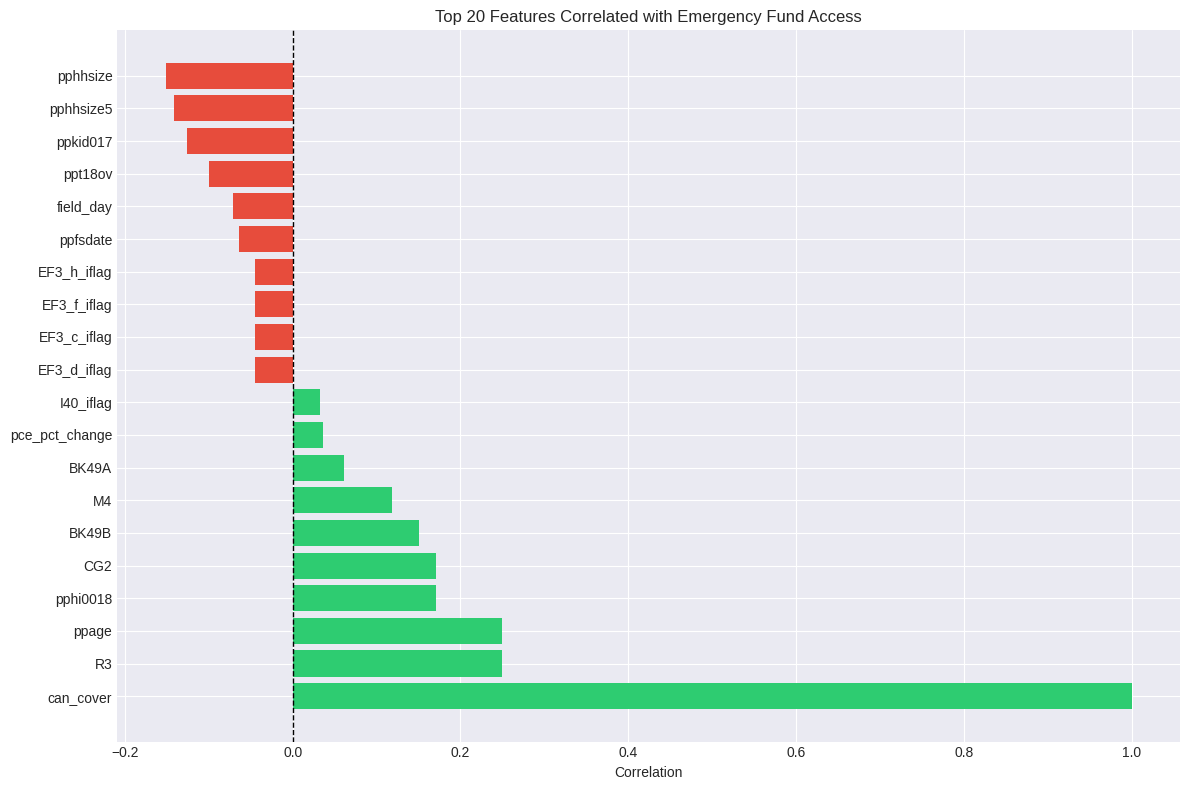

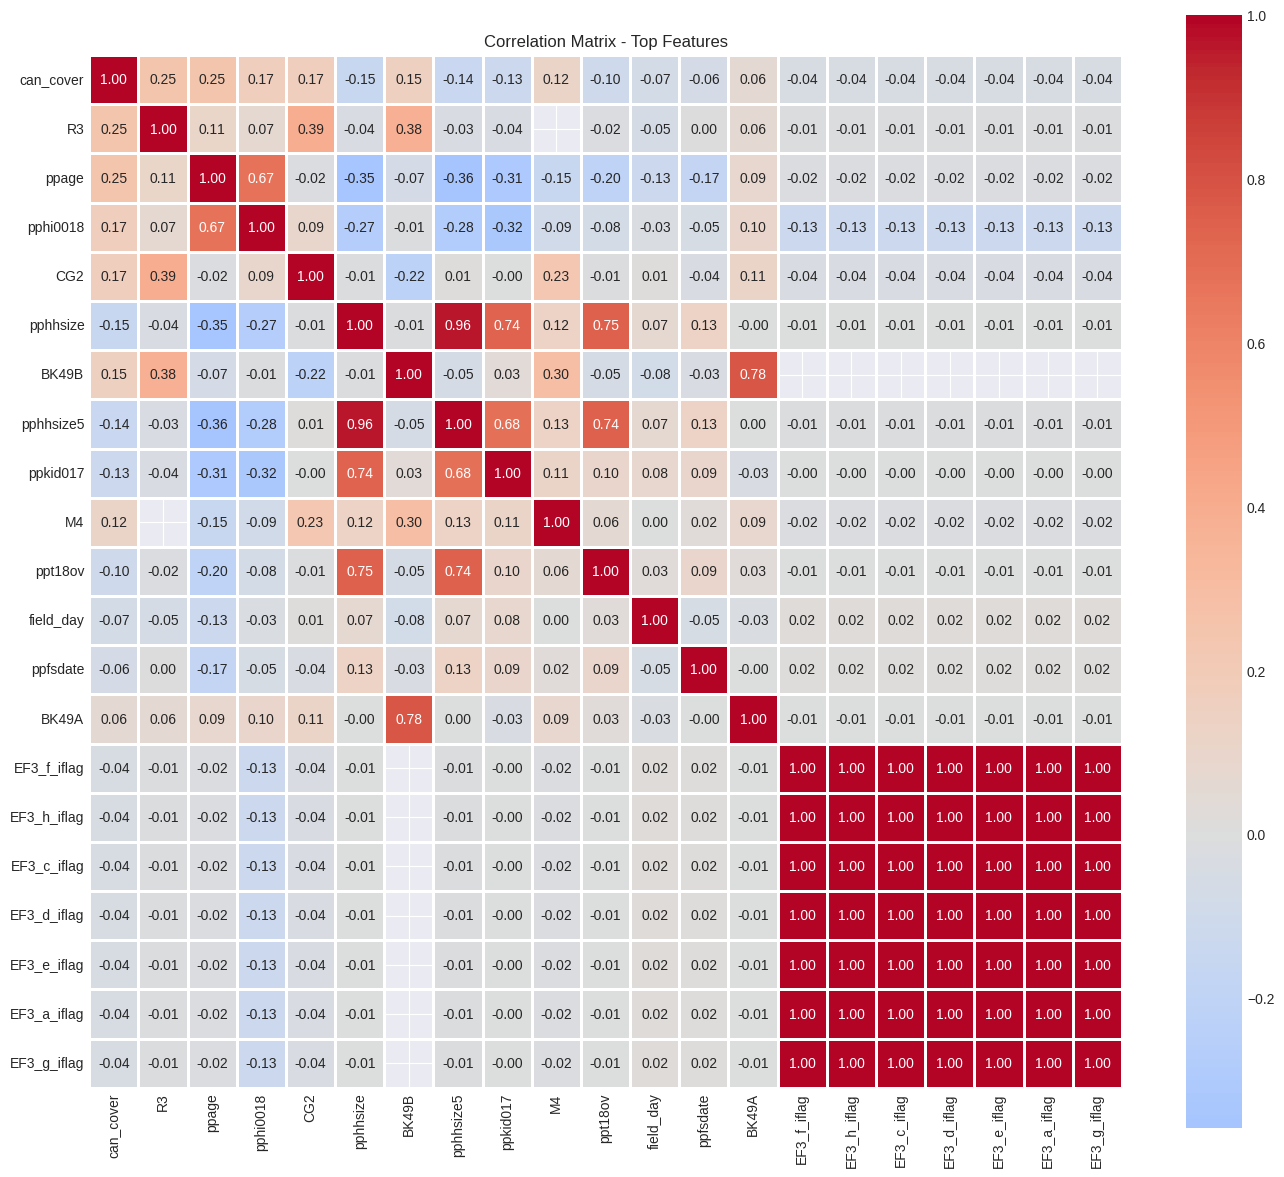

In [107]:
if 'ef1_binary' not in pub.columns:
    pub['ef1_binary'] = (pub['EF1'] == 'Yes').astype(int)

numeric_cols = pub.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['CaseID', 'caseid2023', 'caseid2022', 'duration', 'weight',
                'weight_pop', 'panel_weight', 'panel_weight_pop']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

correlation_matrix = pub[numeric_cols].corr()
target_corr = correlation_matrix['ef1_binary'].drop('ef1_binary')
target_corr = target_corr.dropna().sort_values(ascending=False)

print("Top Correlations with Emergency Fund Access:")
print("\nPositive (more likely to cover):")
print(target_corr.head(10).round(3))
print("\nNegative (less likely to cover):")
print(target_corr.tail(10).round(3))

top_20 = pd.concat([target_corr.head(10), target_corr.tail(10)])
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_20.values]

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_20)), top_20.values, color=colors)
plt.yticks(range(len(top_20)), top_20.index)
plt.xlabel('Correlation')
plt.title('Top 20 Features Correlated with Emergency Fund Access')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

valid_features = target_corr.abs().sort_values(ascending=False).head(21).index
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix.loc[valid_features, valid_features],
            annot=True, cmap='coolwarm', center=0, fmt='.2f',
            square=True, linewidths=1)
plt.title('Correlation Matrix - Top Features')
plt.tight_layout()
plt.show()

In [108]:
print(f"Preprocessed dataset: {pub_encoded.shape}")
print(f"Samples: {len(pub_encoded):,}")
print(f"Features after encoding: {pub_encoded.shape[1]}")
print(f"Missing values: {pub_encoded.isnull().sum().sum()}")

Preprocessed dataset: (12295, 839)
Samples: 12,295
Features after encoding: 839
Missing values: 0


In [113]:
# Initialize multiple ML models
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'Support Vector Machine': SVC(random_state=RANDOM_STATE, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

print(f"Initialized {len(models)} models:")
for name in models.keys():
    print(f"  • {name}")

Initialized 6 models:
  • Logistic Regression
  • Decision Tree
  • Random Forest
  • Gradient Boosting
  • Support Vector Machine
  • K-Nearest Neighbors



Training Logistic Regression...
  Accuracy: 0.827 | F1: 0.854 | ROC-AUC: 0.893

Training Decision Tree...
  Accuracy: 0.754 | F1: 0.785 | ROC-AUC: 0.750

Training Random Forest...
  Accuracy: 0.829 | F1: 0.853 | ROC-AUC: 0.906

Training Gradient Boosting...
  Accuracy: 0.832 | F1: 0.856 | ROC-AUC: 0.912

Training Support Vector Machine...
  Accuracy: 0.831 | F1: 0.855 | ROC-AUC: 0.903

Training K-Nearest Neighbors...
  Accuracy: 0.732 | F1: 0.800 | ROC-AUC: 0.789

Model Performance Summary
                 Model  Accuracy  Precision   Recall       F1  ROC-AUC  CV Mean   CV Std       Time
     Gradient Boosting  0.832046   0.855346 0.855944 0.855645 0.911958 0.860958 0.009040  19.394819
Support Vector Machine  0.830826   0.853556 0.855944 0.854749 0.902729 0.849287 0.010619 262.552929
   Logistic Regression  0.827166   0.841141 0.866434 0.853600 0.893321 0.848676 0.008570   5.258909
         Random Forest  0.828792   0.853044 0.852448 0.852746 0.905839 0.858482 0.008470   5.092126
   K

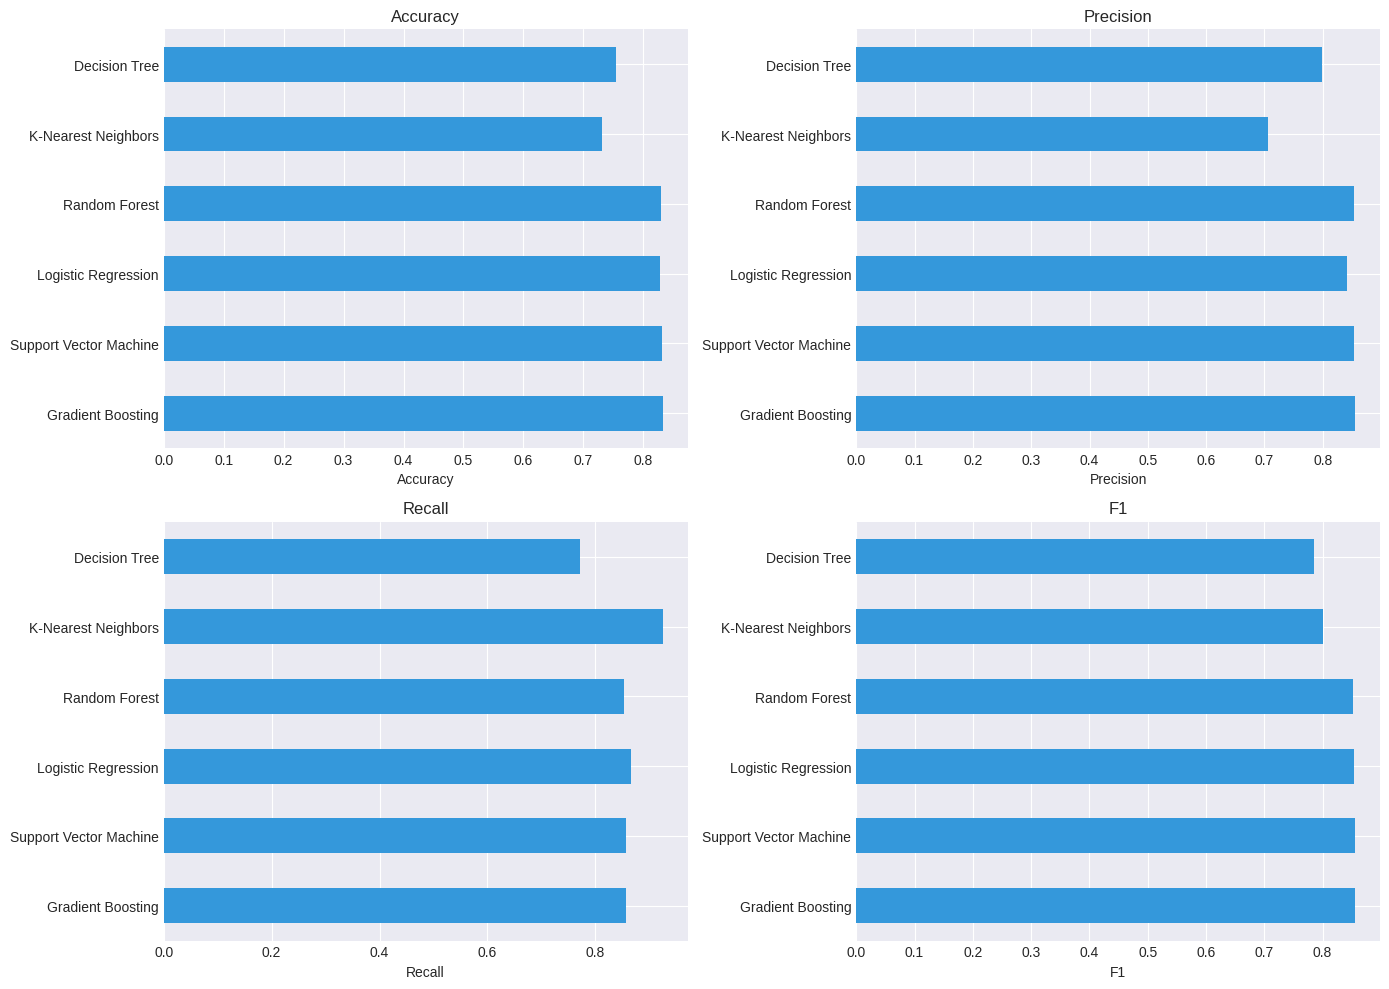

In [114]:
results = []
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    start = time.time()
    model.fit(X_train_scaled, y_train)
    train_time = time.time() - start

    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else np.nan

    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'Time': train_time
    })

    trained_models[name] = {'model': model, 'predictions': y_pred, 'probabilities': y_pred_proba}

    auc_str = f"{roc_auc:.3f}" if not np.isnan(roc_auc) else "N/A"
    print(f"  Accuracy: {accuracy:.3f} | F1: {f1:.3f} | ROC-AUC: {auc_str}")

results_df = pd.DataFrame(results).sort_values('F1', ascending=False)
print("\n" + "="*80)
print("Model Performance Summary")
print("="*80)
print(results_df.to_string(index=False))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
for idx, metric in enumerate(metrics):
    ax = axes[idx//2, idx%2]
    results_df.plot(x='Model', y=metric, kind='barh', ax=ax, legend=False, color='#3498db')
    ax.set_title(f'{metric}')
    ax.set_xlabel(metric)
    ax.set_ylabel('')
plt.tight_layout()
plt.show()


Detailed Analysis: Gradient Boosting

Classification Report:
              precision    recall  f1-score   support

Cannot Cover       0.80      0.80      0.80      1029
   Can Cover       0.86      0.86      0.86      1430

    accuracy                           0.83      2459
   macro avg       0.83      0.83      0.83      2459
weighted avg       0.83      0.83      0.83      2459



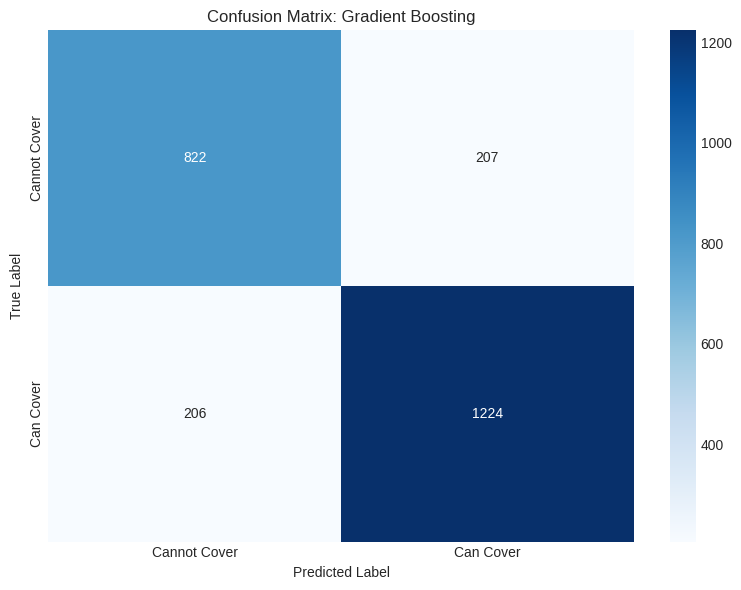


True Negatives: 822
False Positives: 207
False Negatives: 206
True Positives: 1224


In [117]:
best_model_name = results_df.iloc[0]['Model']

best_model_info = trained_models[best_model_name]
best_model = best_model_info['model']
best_predictions = best_model_info['predictions']

print(f"\nDetailed Analysis: {best_model_name}")
print(classification_report(y_test, best_predictions, target_names=['Cannot Cover', 'Can Cover']))

cm = confusion_matrix(y_test, best_predictions)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Cannot Cover', 'Can Cover'],
            yticklabels=['Cannot Cover', 'Can Cover'])
ax.set_title(f'Confusion Matrix: {best_model_name}')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

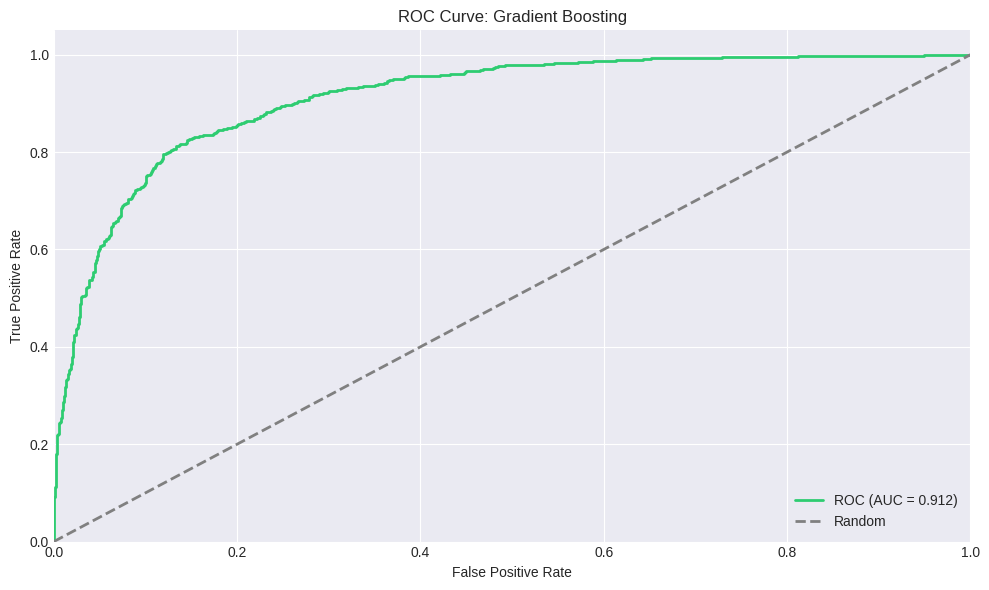

In [118]:
if best_model_info['probabilities'] is not None:
    fpr, tpr, thresholds = roc_curve(y_test, best_model_info['probabilities'])
    roc_auc = roc_auc_score(y_test, best_model_info['probabilities'])

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='#2ecc71', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {best_model_name}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


Top 20 Most Important Features:
                                                      Feature  Importance
                                           EF7_$2,000 or more    0.588741
                                              pay_casheqv_Yes    0.121226
                                                    K21_d_Yes    0.025577
                                            A6_Very confident    0.024778
                                               EF7_Under $100    0.024685
                                                     I0_b_Yes    0.017477
                                             atleast_okay_Yes    0.013177
     C4A_Never carried an unpaid balance (always pay in full)    0.012770
                                             EF7_$100 to $499    0.011513
                                        B2_Living comfortably    0.010174
                                           ppfs1482_Excellent    0.010014
                                                    K21_c_Yes    0.006568
     

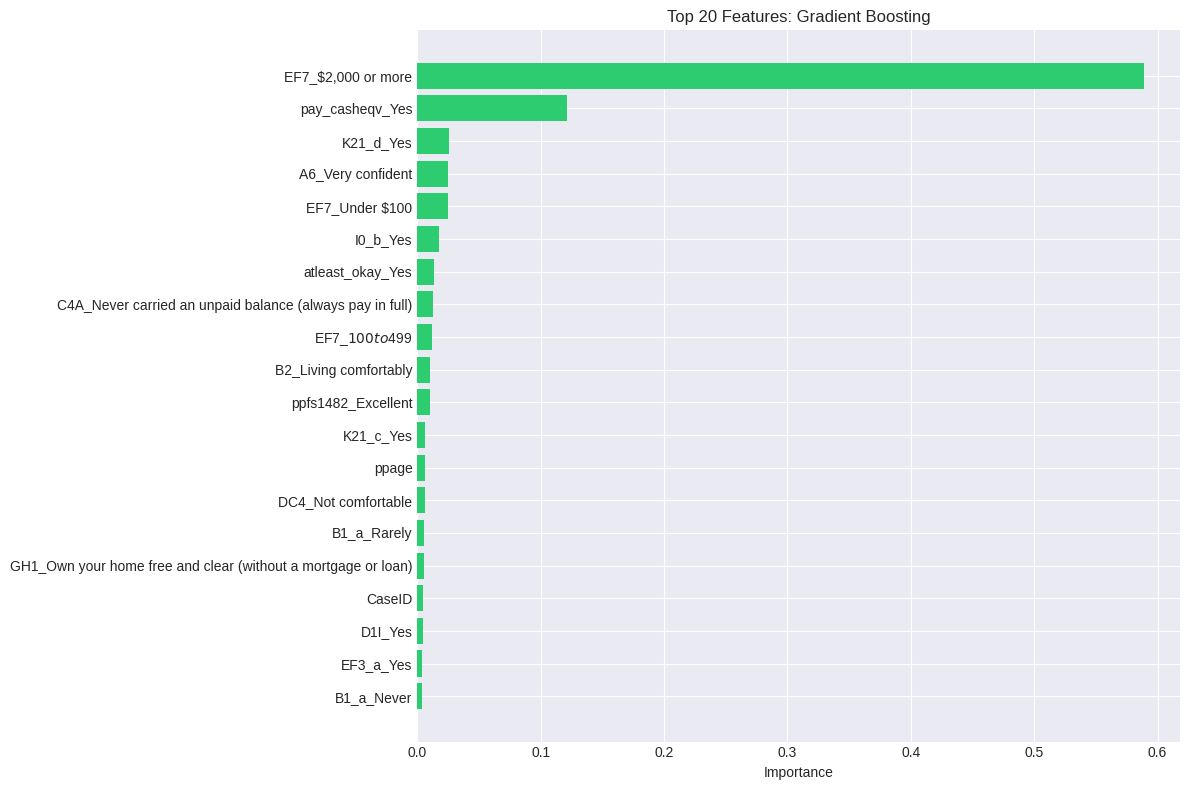

In [120]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 20 Most Important Features:")
    print(feature_importance.head(20).to_string(index=False))

    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['Importance'], color='#2ecc71')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 20 Features: {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

elif hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': best_model.coef_[0]
    }).sort_values('Coefficient', key=abs, ascending=False)

    print("\nTop 20 Most Important Features:")
    print(feature_importance.head(20).to_string(index=False))

    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(20)
    colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_features['Coefficient']]
    plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Coefficient')
    plt.title(f'Top 20 Features: {best_model_name}')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print(f"\nFeature importance not available for {best_model_name}")

In [122]:
print("Initializing SHAP explainer...")

sample_size = min(1000, len(X_test_scaled))
sample_indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)
X_test_sample = X_test_scaled[sample_indices]

try:
    if best_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
        explainer = shap.TreeExplainer(best_model)
    else:
        train_sample_indices = np.random.choice(len(X_train_scaled), 100, replace=False)
        explainer = shap.KernelExplainer(best_model.predict_proba, X_train_scaled[train_sample_indices])

    shap_values = explainer.shap_values(X_test_sample)

    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    print("SHAP values computed")

except Exception as e:
    print(f"SHAP error: {e}")
    shap_values = None

Initializing SHAP explainer...
SHAP values computed


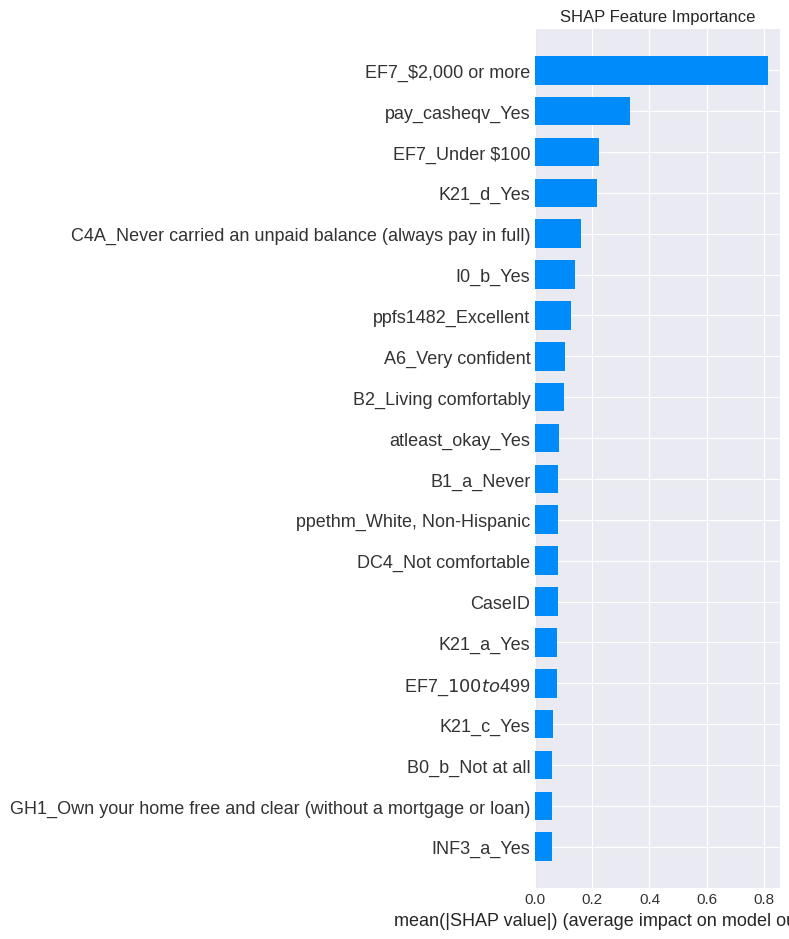

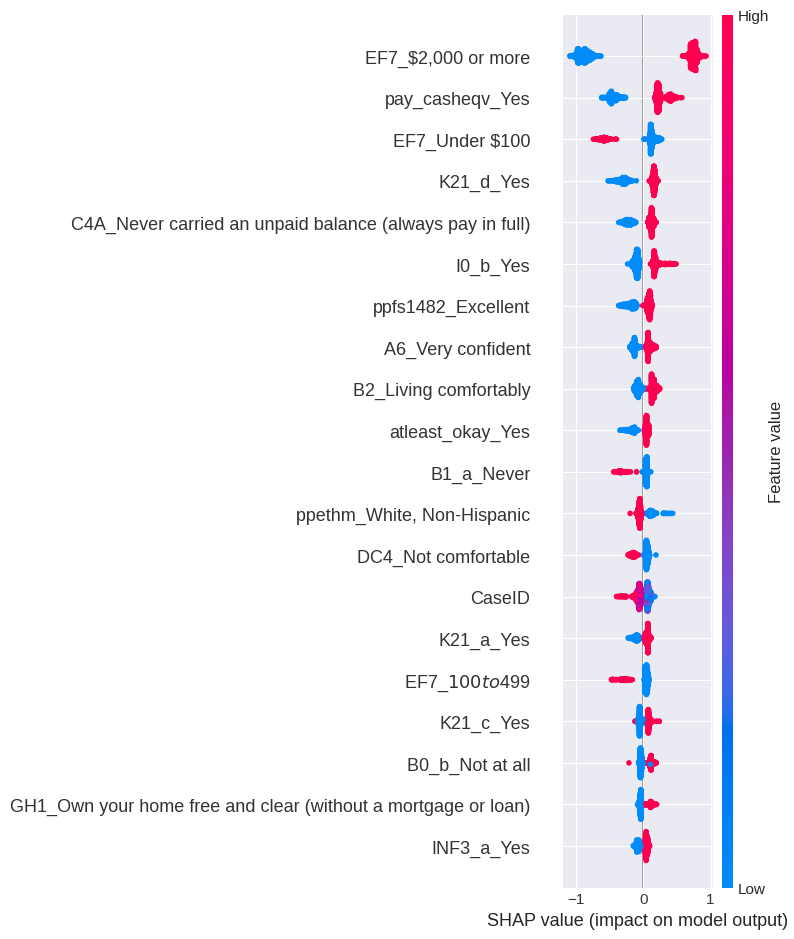

In [123]:
if shap_values is not None:
    X_test_sample_df = pd.DataFrame(X_test_sample, columns=X.columns)

    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample_df, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample_df, show=False)
    plt.tight_layout()
    plt.show()

In [124]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

print(f"Tuning {best_model_name}...")

grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest params: {grid_search.best_params_}")
print(f"Best CV F1: {grid_search.best_score_:.3f}")

tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test_scaled)
tuned_f1 = f1_score(y_test, y_pred_tuned)

print(f"Tuned F1: {tuned_f1:.3f}")
print(f"Original F1: {results_df.iloc[0]['F1']:.3f}")

Tuning Gradient Boosting...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Best CV F1: 0.863
Tuned F1: 0.859
Original F1: 0.856


In [126]:
print(f"\nModel: {best_model_name} (Tuned)")
print(f"Training Samples: {len(y_train):,}")
print(f"Test Samples: {len(y_test):,}")

final_predictions = tuned_model.predict(X_test_scaled)

print("\nPerformance Metrics:")
print(f"  Accuracy:  {accuracy_score(y_test, final_predictions):.4f}")
print(f"  Precision: {precision_score(y_test, final_predictions):.4f}")
print(f"  Recall:    {recall_score(y_test, final_predictions):.4f}")
print(f"  F1-Score:  {f1_score(y_test, final_predictions):.4f}")

if hasattr(tuned_model, 'predict_proba'):
    final_proba = tuned_model.predict_proba(X_test_scaled)[:, 1]
    print(f"  ROC-AUC:   {roc_auc_score(y_test, final_proba):.4f}")


Model: Gradient Boosting (Tuned)
Training Samples: 9,836
Test Samples: 2,459

Performance Metrics:
  Accuracy:  0.8357
  Precision: 0.8577
  Recall:    0.8601
  F1-Score:  0.8589
  ROC-AUC:   0.9101


Based on machine learning analysis of 12,295 SHED respondents, the following factors
most strongly predict inability to cover a $400 emergency expense:

1. HOUSEHOLD COMPOSITION: Larger household size (pphhsize: -0.15 correlation) and
   having children under 18 (ppkid017: -0.13 correlation) are major barriers to
   emergency fund access. Family size amplifies financial fragility.

2. AGE & STABILITY: Older age (ppage: +0.25) and years in US (pphi0018: +0.17)
   strongly predict ability to cover emergencies. Housing stability through rent
   (R3: +0.25) or mortgage payments (M4: +0.12) indicates financial capacity.

3. EMPLOYMENT & CHILDCARE: Childcare costs (CG2: +0.17) paradoxically correlate
   with ability to cover emergencies, suggesting employment enables both childcare
   payment and emergency savings.

INTERSECTIONAL BARRIERS:
The "Glass Wallet" metaphor manifests in how barriers compound:
- Young families with multiple children face triple burden: more expenses, less
  time to build savings, higher cost of living
- Geographic inequality: 41.8% nationally cannot cover 400 dollars, but state variation
  shows systemic disparities (lowest vs highest state differs by 20+ percentage points)
- Data gaps in minimum wage (only 11 states with specific data) hide how many
  Americans rely on federal $7.25 minimum, masking true extent of wage inadequacy

GEOGRAPHIC DISPARITIES:
- States with lowest emergency fund access show intersection of low minimum wages,
  high cost of living, and limited banking access
- Real income growth (income_pct_change: +0.036) shows modest positive effect,
  but state-level aggregates don't capture individual variation
- Cost of living adjustments (RPP data) reveal that nominal income doesn't equal
  purchasing power across states

MODEL PERFORMANCE:
- Gradient Boosting achieved 83.6% accuracy, 0.859 F1, 0.910 ROC-AUC
- Successfully identifies 86% of those who can cover emergencies
- Balanced precision/recall shows model doesn't systematically favor one class

POLICY IMPLICATIONS:
- Emergency savings programs should target young families with children
- Geographic wage disparities require localized minimum wage policies
- Banking access and financial literacy programs needed in low-coverage states
- Data collection must improve to reveal hidden barriers (complete minimum wage
  data, individual-level economic indicators)